In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [ ]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [ ]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [ ]:
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [ ]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [ ]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [ ]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [ ]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [ ]:
model = get_cnn_model(data)

In [ ]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [2.2556675, tensor(0.1668)]
valid: [2.36210234375, tensor(0.2738)]
CPU times: user 11.6 s, sys: 11.1 s, total: 22.6 s
Wall time: 5.69 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [ ]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [ ]:
cbfs.append(CudaCallback)

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [1.72966375, tensor(0.4247, device='cuda:0')]
valid: [0.774974267578125, tensor(0.7620, device='cuda:0')]
train: [0.29939634765625, tensor(0.9118, device='cuda:0')]
valid: [0.19755487060546875, tensor(0.9433, device='cuda:0')]
train: [0.16420533203125, tensor(0.9504, device='cuda:0')]
valid: [0.125843017578125, tensor(0.9638, device='cuda:0')]
CPU times: user 4.51 s, sys: 1.24 s, total: 5.75 s
Wall time: 5.75 s


## Refactor model

First we can regroup all the conv/relu in a single function:

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can add the channel dimension in a batch transform, that we can do with a Callback.

In [ ]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [ ]:
run.fit(3, learn)

train: [1.80831375, tensor(0.3670, device='cuda:0')]
valid: [0.508394580078125, tensor(0.8448, device='cuda:0')]
train: [0.32299384765625, tensor(0.9013, device='cuda:0')]
valid: [0.50161015625, tensor(0.8589, device='cuda:0')]
train: [0.18899474609375, tensor(0.9423, device='cuda:0')]
valid: [0.1287885498046875, tensor(0.9620, device='cuda:0')]


## Hooks

Hooks are `PyTorch` object you can add to any `nn.Module`. They will be called when this particular is executed during the forward pass (forward hook) or the backward pass (backward hook).

NB: Hooks won't work as is if you're using multi-GPU training.

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
run.fit(2, learn)

train: [2.32397984375, tensor(0.1439, device='cuda:0')]
valid: [2.3050384765625, tensor(0.1064, device='cuda:0')]
train: [2.220335, tensor(0.1697, device='cuda:0')]
valid: [1.7835640625, tensor(0.3596, device='cuda:0')]


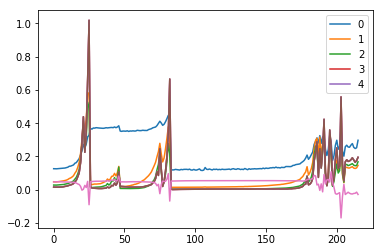

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

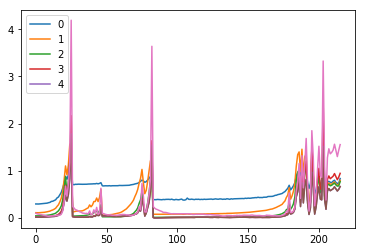

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

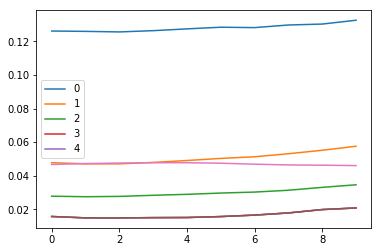

In [ ]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

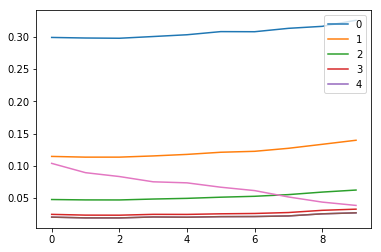

In [ ]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

But hooks don't require us to rewrite the model (if we're using a pretrained model for instance).

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three argument (module, input, output). Here we store the mean and std of the output in the correct position of our list.

In [ ]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [ ]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [ ]:
run.fit(1, learn)

train: [1.61357203125, tensor(0.4651, device='cuda:0')]
valid: [0.3827278076171875, tensor(0.8853, device='cuda:0')]


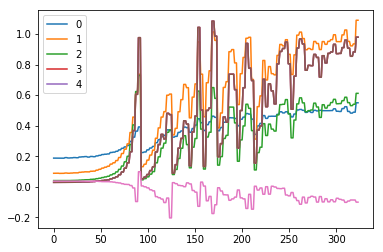

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [ ]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [ ]:
run.fit(1, learn)

train: [2.3119021875, tensor(0.1380, device='cuda:0')]
valid: [2.2882638671875, tensor(0.1069, device='cuda:0')]


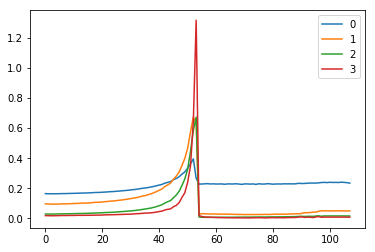

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that will can contain a list of objects. It behaves a bit like a numpy array in the sense that we can index it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [ ]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [ ]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [ ]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks.

In [ ]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self: h.remove()

In [ ]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fe084749898>, <__main__.Hook object at 0x7fe084749438>, <__main__.Hook object at 0x7fe084749cf8>, <__main__.Hook object at 0x7fe084749dd8>, <__main__.Hook object at 0x7fe07c5e2f60>, <__main__.Hook object at 0x7fe07c5e2048>, <__main__.Hook object at 0x7fe07c5e2780>]

In [ ]:
hooks.remove()

In [ ]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [ ]:
x.mean(),x.std()

(tensor(-0.0024, device='cuda:0'), tensor(0.9994, device='cuda:0'))

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1869, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.2032, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3651, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.8333, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.05722265625, tensor(0.3170, device='cuda:0')]
valid: [0.99946845703125, tensor(0.6661, device='cuda:0')]
train: [0.770375, tensor(0.7520, device='cuda:0')]
valid: [0.2995662109375, tensor(0.9036, device='cuda:0')]


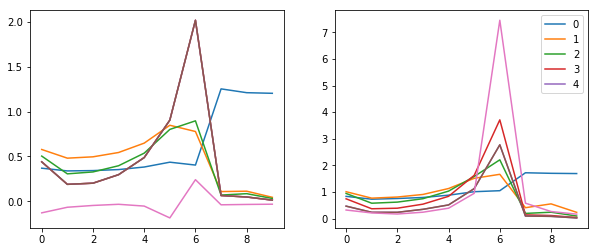

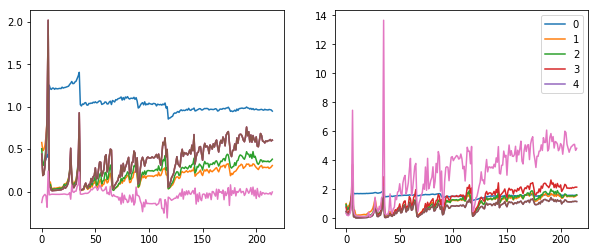

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

### Other statistics

- pct < x
- percentiles

## Generalized ReLU

Nos let's use our model with a generalize ReLU that can be shifted and with maximum value.

In [ ]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.476607734375, tensor(0.8555, device='cuda:0')]
valid: [0.13323577880859375, tensor(0.9606, device='cuda:0')]
train: [0.11674314453125, tensor(0.9648, device='cuda:0')]
valid: [0.09237443237304688, tensor(0.9729, device='cuda:0')]


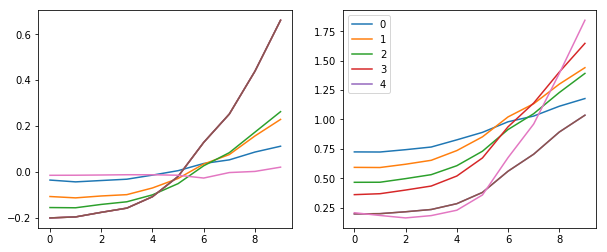

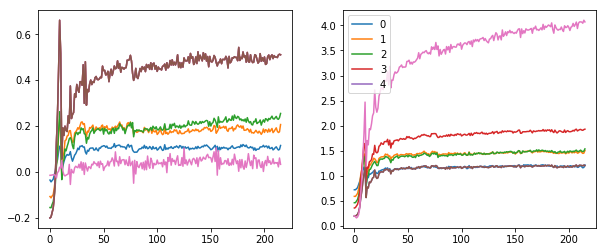

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [1.23159515625, tensor(0.6169, device='cuda:0')]
valid: [0.337270263671875, tensor(0.9011, device='cuda:0')]
train: [0.31986775390625, tensor(0.9025, device='cuda:0')]
valid: [0.2623988525390625, tensor(0.9201, device='cuda:0')]
train: [0.21492517578125, tensor(0.9354, device='cuda:0')]
valid: [0.17729852294921875, tensor(0.9492, device='cuda:0')]
train: [0.24219189453125, tensor(0.9251, device='cuda:0')]
valid: [0.1238900390625, tensor(0.9633, device='cuda:0')]
train: [0.089039609375, tensor(0.9723, device='cuda:0')]
valid: [0.0831210205078125, tensor(0.9743, device='cuda:0')]
train: [0.0621661279296875, tensor(0.9806, device='cuda:0')]
valid: [0.07253018798828124, tensor(0.9788, device='cuda:0')]
train: [0.0459348828125, tensor(0.9861, device='cuda:0')]
valid: [0.07031463623046875, tensor(0.9795, device='cuda:0')]
train: [0.0377228564453125, tensor(0.9887, device='cuda:0')]
valid: [0.06950011596679688, tensor(0.9804, device='cuda:0')]


## Export

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to nb_06.py
